### Ejercicio 6: Problema de transporte multiobjetivo Multiobjective transportation problem

Una compañía tiene dos plantas en Liverpool y Brighton las cuales venden a tres mercados (Cambridge, London y Manchester). El coste y la huella de carbono asociada al transporte una tonelada de producto se muestran en la siguiente tabla:

|           |            | Coste ($/ton) | Huella de carbono (kgCO2/ton) |
|:---------:|------------|:-------------:|:-----------------------------:|
| Liverpool | Cambridge  |      450      |              1100             |
|           | London     |      600      |              1400             |
|           | Manchester |      125      |              450              |
| Brighton  | Cambridge  |      350      |              1700             |
|           | London     |      275      |              1550             |
|           | Manchester |      700      |              2400             |

La capacidad máxima de cada planta es de 750 y 600 ton (Liverpool y Brighton respectivamente). La demanda mínima a satisfacer de los mercados (Cambridge, London y Manchester) es de 225, 500 y 275 ton.

1. Formula el modelo como un problema lineal multiobjetivo para determinar la cantidad de producto óptima a transportar

3. Calcula 10 puntos del frente de pareto (coste total vs huella de carbono) e identifica las soluciones más prometedoras

Sugerencia: calcula los puntos ideal y nadir y después define los valores de epsilon para huella de carbono dividiendo en intervalos regulares. 

#### Procesamos los datos del enunciado

In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import pandas as pd

transport_cost = ConcreteModel()

plants=['liverpool', 'brighton']
markets=['cambridge','london','manchester']


In [12]:
capacity=pd.DataFrame(index=plants)
capacity['capacity']=[750,600]

demand=pd.DataFrame(index=markets)
demand['demand']=[225,500,275]

index=pd.MultiIndex.from_product([plants, markets])
cost_gwp = pd.DataFrame({'cost': [450,600,125,350,275,700],
                       'gwp': [1100,1400,450,1700,1550,2400]})
cost_gwp=cost_gwp.set_index(index)['cost']
print(cost_gwp)

liverpool  cambridge     450
           london        600
           manchester    125
brighton   cambridge     350
           london        275
           manchester    700
Name: cost, dtype: int64


#### Creamos los sets de PYOMO

In [3]:
transport_cost.plants=Set(initialize=plants)
transport_cost.markets=Set(initialize=markets)

#### Definimos la variable cantidad a transportar desde cada planta a cada mercado

In [4]:
transport_cost.X=Var(plants,markets, domain=NonNegativeReals)
transport_cost.X.pprint()

X : Size=6, Index=X_index
    Key                         : Lower : Value : Upper : Fixed : Stale : Domain
      ('brighton', 'cambridge') :     0 :  None :  None : False :  True : NonNegativeReals
         ('brighton', 'london') :     0 :  None :  None : False :  True : NonNegativeReals
     ('brighton', 'manchester') :     0 :  None :  None : False :  True : NonNegativeReals
     ('liverpool', 'cambridge') :     0 :  None :  None : False :  True : NonNegativeReals
        ('liverpool', 'london') :     0 :  None :  None : False :  True : NonNegativeReals
    ('liverpool', 'manchester') :     0 :  None :  None : False :  True : NonNegativeReals


#### Resolvemos el problema de mínimo coste

In [5]:
# Objetivo de coste
def cost(modelo):
    return sum(sum(cost_gwp['cost'][p,m]*modelo.X[p,m] for m in markets) for p in plants)
                    
transport_cost.objective = Objective(rule=cost, sense=minimize)

# Restricciones
transport_cost.constraints = ConstraintList()
for p in plants:
    transport_cost.constraints.add(sum(transport_cost.X[p,m] for m in markets)<=capacity['capacity'][p])
for m in markets:    
    transport_cost.constraints.add(sum(transport_cost.X[p,m] for p in plants)>=demand['demand'][m])
results_cost = SolverFactory('glpk').solve(transport_cost).write()
transport_cost.pprint()
zcl=value(transport_cost.objective)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 263125.0
  Upper bound: 263125.0
  Number of objectives: 1
  Number of constraints: 6
  Number of variables: 7
  Number of nonzeros: 13
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.03498268127441406
# ----------------------------------------------------------
#   Solution Information
# ------------------------------

#### Siguiente modelo transport_gwp para minimizar la huella de carbono. Con esto ya tenemos los mínimos de los dos objetivos (punto ideal)

In [6]:
transport_gwp = ConcreteModel()
transport_gwp.plants=Set(initialize=plants)
transport_gwp.markets=Set(initialize=markets)
transport_gwp.X=Var(plants,markets, domain=NonNegativeReals)

# Objetivo 
def gwp(modelo):
    return sum(sum(cost_gwp['gwp'][p,m]*modelo.X[p,m] for m in markets) for p in plants)
                    
transport_gwp.objective = Objective(rule = gwp, sense=minimize)

# Restricciones
transport_gwp.constraints = ConstraintList()
for p in plants:
    transport_gwp.constraints.add(sum(transport_gwp.X[p,m] for m in markets)<=capacity['capacity'][p])
for m in markets:    
    transport_gwp.constraints.add(sum(transport_gwp.X[p,m] for p in plants)>=demand['demand'][m])

results_gwp = SolverFactory('glpk').solve(transport_gwp).write()
transport_gwp.pprint()
zgl=value(transport_gwp.objective)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 1108750.0
  Upper bound: 1108750.0
  Number of objectives: 1
  Number of constraints: 6
  Number of variables: 7
  Number of nonzeros: 13
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.03841876983642578
# ----------------------------------------------------------
#   Solution Information
# ----------------------------

#### El siguiente paso será calcular el punto nadir. Para ello minimizaremos el coste imponiendo como constraint que el gwp sea menor o igual que el valor menor de gwp calculado hasta ahora (zgl). Resolvemos transport_cost_epsgwp


In [7]:
transport_cost_epsgwp = ConcreteModel()
transport_cost_epsgwp.plants=Set(initialize=plants)
transport_cost_epsgwp.markets=Set(initialize=markets)
transport_cost_epsgwp.X=Var(plants,markets, domain=NonNegativeReals)

def gwp_cost(modelo):
    return sum(sum(cost_gwp['gwp'][p,m]*modelo.X[p,m] for m in markets) for p in plants)<=zgl

epsilon=zgl
transport_cost_epsgwp.gwp=Constraint(rule=gwp_cost)

#Objetivo
transport_cost_epsgwp.objective = Objective(rule = cost, sense=minimize)


# Restricciones
transport_cost_epsgwp.constraints = ConstraintList()
for p in plants:
    transport_cost_epsgwp.constraints.add(sum(transport_cost_epsgwp.X[p,m] for m in markets)<=capacity['capacity'][p])

for m in markets:    
    transport_cost_epsgwp.constraints.add(sum(transport_cost_epsgwp.X[p,m] for p in plants)>=demand['demand'][m])

 
results_cost_epsgwp = SolverFactory('glpk').solve(transport_cost_epsgwp).write()
transport_cost_epsgwp.pprint()
zcu=value(transport_cost_epsgwp.objective)

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 354375.0
  Upper bound: 354375.0
  Number of objectives: 1
  Number of constraints: 7
  Number of variables: 7
  Number of nonzeros: 19
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.03166007995605469
# ----------------------------------------------------------
#   Solution Information
# ------------------------------

#### Con lo anterior, tendríamos el valor del menor coste para el caso de impooner el mínimo valor de huella de carbono. Ahora haremos lo contrario: calculamos la menor huella de carbono, imponiendo el valor mínimo del coste (zcl). Resolvemos transport_gwp_epscost

In [8]:
def transport_gwp_epscostf(epsilon):
    transport_gwp_epscost = ConcreteModel()
    transport_gwp_epscost.plants=Set(initialize=plants)
    transport_gwp_epscost.markets=Set(initialize=markets)
    transport_gwp_epscost.X=Var(plants,markets, domain=NonNegativeReals)
    def cost_gwpf(modelo):
        return sum(sum(cost_gwp['cost'][p,m]*modelo.X[p,m] for m in markets) for p in plants)<=epsilon

    transport_gwp_epscost.objective = Objective(rule=gwp, sense=minimize)

    # Restricciones
    transport_gwp_epscost.constraints = ConstraintList()
    for p in plants:
        transport_gwp_epscost.constraints.add(sum(transport_gwp_epscost.X[p,m] for m in markets)<=capacity['capacity'][p])

    for m in markets:    
        transport_gwp_epscost.constraints.add(sum(transport_gwp_epscost.X[p,m] for p in plants)>=demand['demand'][m])

    transport_gwp_epscost.costa=Constraint(rule=cost_gwpf)
 
    results_gwp_epscost = SolverFactory('glpk').solve(transport_gwp_epscost)
    transport_gwp_epscost.pprint()
    zgg=value(transport_gwp_epscost.objective)
    zcc=value(transport_gwp_epscost.costa)
      
    return zgg,zcc
   
    
epsilon=zcl
zgu=transport_gwp_epscostf(epsilon)[0]


6 Set Declarations
    X_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : X_index_0*X_index_1 :    6 : {('liverpool', 'cambridge'), ('liverpool', 'london'), ('liverpool', 'manchester'), ('brighton', 'cambridge'), ('brighton', 'london'), ('brighton', 'manchester')}
    X_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'liverpool', 'brighton'}
    X_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 'london', 'manchester'}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    markets : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 

#### Con esto tenemos los upper y lower bound de los objetivos individuales

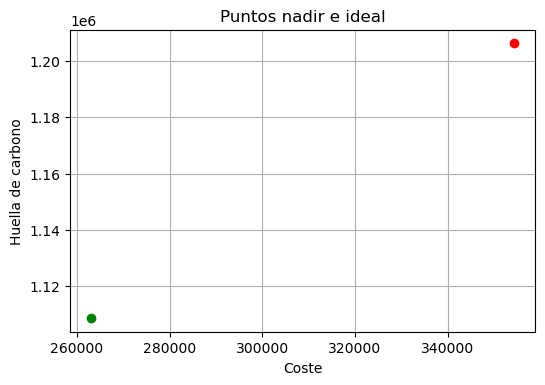

In [9]:
fig, ax = plt.subplots()
fig.set_dpi(100)

ax.plot(zcu,zgu,'ro')
ax.plot(zcl,zgl,'go')
ax.set(title='Puntos nadir e ideal',xlabel="Coste",ylabel="Huella de carbono");
ax.grid(True);  



#### Calculamos el frente de pareto del problema utilizando el método de $\epsilon$-constraint

In [10]:
n=10
zg_l = []
zc_l = []
eps ={}
for l in range(n+1):
    epsilon=zcl+(zcu-zcl)/n*l
    eps[l]=epsilon
    zg_l.append(transport_gwp_epscostf(epsilon)[0])
    zc_l.append(transport_gwp_epscostf(epsilon)[1])

6 Set Declarations
    X_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : X_index_0*X_index_1 :    6 : {('liverpool', 'cambridge'), ('liverpool', 'london'), ('liverpool', 'manchester'), ('brighton', 'cambridge'), ('brighton', 'london'), ('brighton', 'manchester')}
    X_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'liverpool', 'brighton'}
    X_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 'london', 'manchester'}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    markets : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 

6 Set Declarations
    X_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : X_index_0*X_index_1 :    6 : {('liverpool', 'cambridge'), ('liverpool', 'london'), ('liverpool', 'manchester'), ('brighton', 'cambridge'), ('brighton', 'london'), ('brighton', 'manchester')}
    X_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'liverpool', 'brighton'}
    X_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 'london', 'manchester'}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    markets : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 

6 Set Declarations
    X_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : X_index_0*X_index_1 :    6 : {('liverpool', 'cambridge'), ('liverpool', 'london'), ('liverpool', 'manchester'), ('brighton', 'cambridge'), ('brighton', 'london'), ('brighton', 'manchester')}
    X_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'liverpool', 'brighton'}
    X_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 'london', 'manchester'}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    markets : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 

6 Set Declarations
    X_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : X_index_0*X_index_1 :    6 : {('liverpool', 'cambridge'), ('liverpool', 'london'), ('liverpool', 'manchester'), ('brighton', 'cambridge'), ('brighton', 'london'), ('brighton', 'manchester')}
    X_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'liverpool', 'brighton'}
    X_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 'london', 'manchester'}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    markets : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 

6 Set Declarations
    X_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : X_index_0*X_index_1 :    6 : {('liverpool', 'cambridge'), ('liverpool', 'london'), ('liverpool', 'manchester'), ('brighton', 'cambridge'), ('brighton', 'london'), ('brighton', 'manchester')}
    X_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'liverpool', 'brighton'}
    X_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 'london', 'manchester'}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    markets : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 

6 Set Declarations
    X_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : X_index_0*X_index_1 :    6 : {('liverpool', 'cambridge'), ('liverpool', 'london'), ('liverpool', 'manchester'), ('brighton', 'cambridge'), ('brighton', 'london'), ('brighton', 'manchester')}
    X_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'liverpool', 'brighton'}
    X_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 'london', 'manchester'}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    markets : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 

6 Set Declarations
    X_index : Size=1, Index=None, Ordered=True
        Key  : Dimen : Domain              : Size : Members
        None :     2 : X_index_0*X_index_1 :    6 : {('liverpool', 'cambridge'), ('liverpool', 'london'), ('liverpool', 'manchester'), ('brighton', 'cambridge'), ('brighton', 'london'), ('brighton', 'manchester')}
    X_index_0 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'liverpool', 'brighton'}
    X_index_1 : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 'london', 'manchester'}
    constraints_index : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {1, 2, 3, 4, 5}
    markets : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    3 : {'cambridge', 

        Key  : Active : Sense    : Expression
        None :   True : minimize : 1100*X[liverpool,cambridge] + 1400*X[liverpool,london] + 450*X[liverpool,manchester] + 1700*X[brighton,cambridge] + 1550*X[brighton,london] + 2400*X[brighton,manchester]

2 Constraint Declarations
    constraints : Size=5, Index=constraints_index, Active=True
        Key : Lower : Body                                                                   : Upper : Active
          1 :  -Inf : X[liverpool,cambridge] + X[liverpool,london] + X[liverpool,manchester] : 750.0 :   True
          2 :  -Inf :    X[brighton,cambridge] + X[brighton,london] + X[brighton,manchester] : 600.0 :   True
          3 : 225.0 :                         X[liverpool,cambridge] + X[brighton,cambridge] :  +Inf :   True
          4 : 500.0 :                               X[liverpool,london] + X[brighton,london] :  +Inf :   True
          5 : 275.0 :                       X[liverpool,manchester] + X[brighton,manchester] :  +Inf :   True

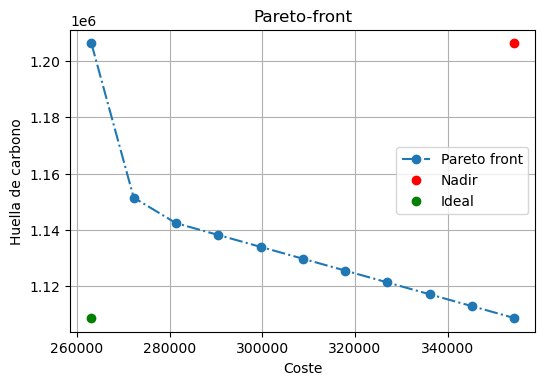

In [11]:
fig, ax = plt.subplots()
fig.set_dpi(100)
plt.plot(zc_l,zg_l,'o-.', label='Pareto front');
plt.plot(zcu,zgu,'ro',label='Nadir');
plt.plot(zcl,zgl,'go',label='Ideal');
ax.set(title='Pareto-front',xlabel="Coste",ylabel="Huella de carbono");
ax.legend()
ax.grid(True);  
